# Packages and general functions

## Used packages

In [2]:
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas


import os 
from os import listdir
from os.path import isfile, join, splitext

from skimage.color import gray2rgb
from skimage.io import imread, imshow
from skimage.util import invert
from skimage.transform import resize
from skimage.morphology import erosion, dilation, opening, closing, skeletonize, square
from skimage.filters import threshold_isodata, threshold_li, threshold_mean, threshold_minimum, threshold_otsu, threshold_triangle, threshold_yen
from sklearn.cluster import KMeans

## Image processing functions

In [3]:
# Load an image using io.imread. Note that morphology functions only work on gray-scale or binary images: set as_gray = True

def resize_image(image_in):
  image_out = np.ones((100,100), dtype = np.uint8)
  image_out = 255 * image_out
  center_out = 49
  center_in_x = image_in.shape[0]//2
  center_in_y = image_in.shape[1]//2
  zero_x = center_out - center_in_x 
  zero_y = center_out - center_in_y
  for x in range(image_in.shape[0]):
    for y in range(image_in.shape[1]):
      image_out[x + zero_x][y + zero_y] = image_in[x][y]
  return image_out

def resize_image_noChar(image_in):
  # dim = max(image_in.shape[0],image_in.shape[1])
  # image_out = np.ones((image_in.shape[0],image_in.shape[0]), dtype = np.uint8)
  # image_out = 0 * image_out
  # center_out = dim//2
  # center_in_x = image_in.shape[0]//2
  # center_in_y = image_in.shape[1]//2
  # zero_x = center_out - center_in_x 
  # zero_y = center_out - center_in_y
  # for x in range(image_in.shape[0]):
  #   for y in range(image_in.shape[1]):
  #     image_out[x + zero_x][y + zero_y] = image_in[x][y]
  # plt.figure()
  # plt.plot(image_out,'gray')
  # plt.savefig("midProcessImgOut.png")
  return image_in

def load_image(path):
  im_gray = imread(path, as_gray=True)
  im_gray = resize_image(im_gray)
  return im_gray

def load_image_noChar(path):
  im_gray = imread(path, as_gray=True)
  im_gray = resize_image_noChar(im_gray)
  return im_gray

def erosion_image(image, structural_elem = 'None'):
  if structural_elem != 'None':
    return erosion(image, structural_elem)
  else:
    return erosion(image)

def dilation_image(image, structural_elem = 'None'):
  if structural_elem != 'None':
    return dilation(image, structural_elem)
  else:
    return dilation(image)

def opening_image(image, structural_elem = 'None'):
  if structural_elem != 'None':
    return opening(image, structural_elem)
  else:
    return opening(image)

def closing_image(image, structural_elem = 'None'):
  if structural_elem != 'None':
    return closing(image, structural_elem)
  else:
    return closing(image)

def skeletonization_image(image_bin, method):
    image_bin = invert(image_bin)
    if method == "lee":
      skel = skeletonize(image_bin, method = "lee")
    else: 
      skel = skeletonize(image_bin, method = "zhang")
    return skel
  
def binarization_image(image, method):
  if method == "isodata":
    th = threshold_isodata(image)
  elif method == "li":
    th = threshold_li(image)
  elif method == "mean":
    th = threshold_mean(image)
  elif method == "minimum":
    th = threshold_minimum(image)
  elif method == "triangle":
    th = threshold_triangle(image)
  elif method == "yen":
    th = threshold_yen(image)
  else:
    th = threshold_otsu(image)
  print("threshold found : "+str(th))
  binary =( image > th)
  return binary

# FuzzyDoc functions 

In [4]:
def euclidean_distance_minutia(m1, m2):
  return math.sqrt((m1[0] - m2[0])*(m1[0] - m2[0]) + (m1[1] - m2[1])*(m1[1] - m2[1]))

## P&S character pre-processing

In [5]:
def character_preprocessing(path):
  im = load_image(path)
  im_preprocess = opening_image(im, structural_elem = square(3))
  im_bin = binarization_image(im_preprocess, 'otsu')
  im_skeleton = skeletonization_image(im_bin, 'lee')
  return im_skeleton

def character_preprocessing_noChar(path):
  im = load_image_noChar(path)
  im_preprocess = opening_image(im, structural_elem = square(3))
  im_bin = binarization_image(im_preprocess, 'otsu')
  im_skeleton = skeletonization_image(im_bin, 'lee')
  return im_skeleton



## Feature extraction

In [6]:
def minutia_extraction(im_skeleton):
  minutia = []
  h = im_skeleton.shape[0]
  w = im_skeleton.shape[1]
	
  for i in range(1, h-1):
    for j in range(1, w-1):
      P = [ im_skeleton[i][j+1], im_skeleton[i-1][j+1], im_skeleton[i-1][j], im_skeleton[i-1][j-1], im_skeleton[i][j-1], im_skeleton[i+1][j-1], im_skeleton[i+1][j], im_skeleton[i+1][j+1], im_skeleton[i][j+1] ]
      CN = 0
      for k in range(8):
        CN += abs(P[k]/255 - P[k+1]/255)
      CN = 0.5*CN
			
			# 0 : Isolated point
			# 1 : Ending point
			# 2 : Connective point
			# 3 : Bifurcation point
			# 4 : Crossing point
			# Only keep 1, 3 (and 4 ?)
			
      if im_skeleton[i][j] == 255:
        if CN == 1:
          minutia.append((i,j,1))
        elif CN == 3:
          minutia.append((i,j,3))
        elif CN == 4:
          minutia.append((i,j,4))
  
  return minutia

In [7]:
def draw_minutia(minutia, im_skeleton):
  h = im_skeleton.shape[0]
  w = im_skeleton.shape[1]
  im_skeleton_color = gray2rgb(im_skeleton)
  for m in minutia:
    im_skeleton_color[m[0]][m[1]] = (255, 0, 0)
  return im_skeleton_color


def draw_minutiaNB(minutia, im_skeleton):
  h = im_skeleton.shape[0]
  w = im_skeleton.shape[1]
  #im_skeleton_color = gray2rgb(im_skeleton,False)
  im_skeleton_color=np.zeros(im_skeleton.shape)
  for m in minutia:
    im_skeleton_color[m[0]][m[1]] = 1
  return im_skeleton_color

## Smoothing operation

In [8]:
def smoothing(minutia, threshold):
  smooth_minutia = []
  ending_points = []
  smooth_ending_points = []

  for m in minutia:
    if m[2] != 1:
      smooth_minutia.append(m)
    else:
      ending_points.append(m)

  if smooth_minutia == []:
    return minutia
  else:
    for m in ending_points:
      i = 0
      while (i < len(smooth_minutia)) and (euclidean_distance_minutia(m, smooth_minutia[i]) > threshold):
        i = i+1
      if (i == len(smooth_minutia)):
        smooth_ending_points.append(m)

  return smooth_minutia + smooth_ending_points

## Template matching

In [9]:
def template_comparison_v1(template, im_skeleton, smooth):
  minutia = minutia_extraction(im_skeleton)
  if smooth:
    minutia = smoothing(minutia, 15)

  if minutia == []:
    return [], 14

  scores = []
  for i in range(26):
    score_minutia = 0
    if template[i] != []:
      for m in minutia:
        dist_min = 100
        for t in template[i]:
          dist = euclidean_distance_minutia(m, t)
          if dist < dist_min:
            dist_min = dist
        score_minutia += dist_min
      score_minutia /= len(minutia)
      scores.append(score_minutia)
    else:
      scores.append(100)
  return scores, np.argmin(scores)

def template_comparison_v2(template, minutia, smooth):
  minutia = minutia_extraction(im_skeleton)
  if smooth:
    minutia = smoothing(minutia, 15)

  if minutia == []:
    return [], 14

  scores = []
  for i in range(26):
    score_minutia = 0
    if template[i] != []:
      dists = []
      for m in minutia:
        dist_min = 100
        for t in template[i]:
          dist = euclidean_distance_minutia(m, t)
          if dist < dist_min:
            dist_min = dist
        dists.append(dist_min)
      dists = sorted(dists)
      
      for k in range(min(len(template[i]), len(minutia))):
        score_minutia += dists[k]
      score_minutia /= min(len(template[i]), len(minutia))
      scores.append(score_minutia)
    else:
      scores.append(100)
  return scores, np.argmin(scores)

def template_comparison_v3(template, minutia, smooth):
  minutia = minutia_extraction(im_skeleton)
  if smooth:
    minutia = smoothing(minutia, 15)

  if minutia == []:
    return [], 14

  scores = []
  for i in range(26):
    score_minutia = 0
    if abs(len(template[i]) - len(minutia)) <= 2: 
      if template[i] != []:
        for m in minutia:
          dist_min = 100
          for t in template[i]:
            dist = euclidean_distance_minutia(m, t)
            if dist < dist_min:
              dist_min = dist
          score_minutia += dist_min
        score_minutia /= len(minutia)
        scores.append(score_minutia)
      else:
        scores.append(100)
    else:
      scores.append(100)
  return scores, np.argmin(scores)

In [10]:
def template_comparison(template, im_skeleton, smooth, matching_method):
  if matching_method == 1:
    return template_comparison_v1(template, im_skeleton, smooth)
  elif matching_method == 2:
    return template_comparison_v2(template, im_skeleton, smooth)
  else:
    return template_comparison_v3(template, im_skeleton, smooth)

# Main program

## Template building

### Test Félix : inspiré Hough, rot invariant

In [11]:
def listSum(a,b):
    res =[]
    for elem in a:
        res.append(elem)
    if len(a)==len(b):
        for e in range(len(a)) : 
            res[e]+=b[e]
        return res
    return 

def findCentroid(skel):
    moyPos=[0,0]
    count=0
    for tab in range(len(skel)) :
        for pix in range(len(skel[tab])):
            if (skel[tab][pix]!=0): 
                moyPos=listSum(moyPos,[tab,pix])
                count+=1
    return [moyPos[0]/count,moyPos[1]/count]





In [12]:
def houghTransform(skel, angleAcc):
    nH=len(skel)
    nW=len(skel[0])

    diag=math.floor(math.sqrt(nH*nH+nW*nW))

    tabRes=[[0]*diag for i in range(angleAcc)]

    for i in range(nH):
        for j in range(nW):
            if skel[i][j]!=0:
                for angle in range(angleAcc):
                    radAngle=angle*math.pi/angleAcc
                    posTab=math.trunc(i*math.cos(radAngle)+j*math.sin(radAngle))
                    tabRes[angle][posTab]+=1

    return tabRes

def houghTransformFromCentroid(skel, angleAcc):
    nH=len(skel)
    nW=len(skel[0])

    centroid=findCentroid(skel)

    diag=math.floor(math.sqrt(nH*nH+nW*nW))

    tabRes=[[0]*diag for i in range(angleAcc)]

    for i in range(nH):
        for j in range(nW):
            if skel[i][j]!=0:
                for angle in range(angleAcc):
                    radAngle=angle*math.pi/angleAcc         
                    posTab=math.trunc((i-centroid[0])*math.cos(radAngle)+(j-centroid[0])*math.sin(radAngle))
                    tabRes[angle][posTab]+=1

    return tabRes

def normGrayScale(tab):
    nH=len(tab)
    nW=len(tab[0])

    max=tab[0][0]
    min=tab[0][0]

    for i in range(nH):
        for j in range(nW):
            if tab[i][j]>max: max=tab[i][j]
            if tab[i][j]<min: min=tab[i][j]

    for i in range(nH):
        for j in range(nW):
            tab[i][j]=math.floor(255*(tab[i][j]-min)/max)
    return tab

/tmp/ipykernel_2191/437205279.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if structural_elem != 'None':


threshold found : 0.611328125
(19, 479)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


nbr of minutiae : 103


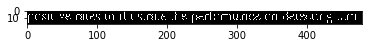

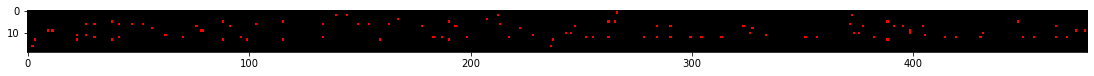

In [14]:
pathLines = "./lines/"
name=pathLines+"line.png"
im_in=load_image_noChar(name)
im_prepr=im_in
im_prepr=opening_image(im_in,structural_elem=square(2))
im_bin=binarization_image(im_prepr,'otsu')
# for x in range(im_bin.shape[0]):
#     for y in range(im_bin.shape[1]):
#         if im_bin[x][y]>0.611:
#             im_bin[x][y]=1
#         else:
#             im_bin[x][y]=0


        
plt.figure()
plt.imshow(im_bin,'gray',interpolation='none')
plt.savefig("line.png")

im_skeleton=skeletonization_image(im_bin,'lee')
plt.figure()
plt.imshow(im_skeleton,'gray',interpolation='none')
plt.savefig("skel.png")
print(im_skeleton.shape)

minutiae=minutia_extraction(im_skeleton)
print("nbr of minutiae : "+str(len(minutiae)))
plt.figure(figsize=(im_skeleton.shape))
plt.imshow(draw_minutia(minutiae,np.zeros(im_skeleton.shape)),interpolation='none')
data = pandas.DataFrame(draw_minutiaNB(minutiae,np.zeros(im_skeleton.shape)))

plt.savefig("minutiae.png",bbox_inches='tight')
# plt.figure()
# plt.imshow(im_skeleton,'gray')

#im_skeleton = character_preprocessing_noChar()



In [ ]:
pandas.set_option("display.max.columns", None)
data

/tmp/ipykernel_29395/264006591.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if structural_elem != 'None':


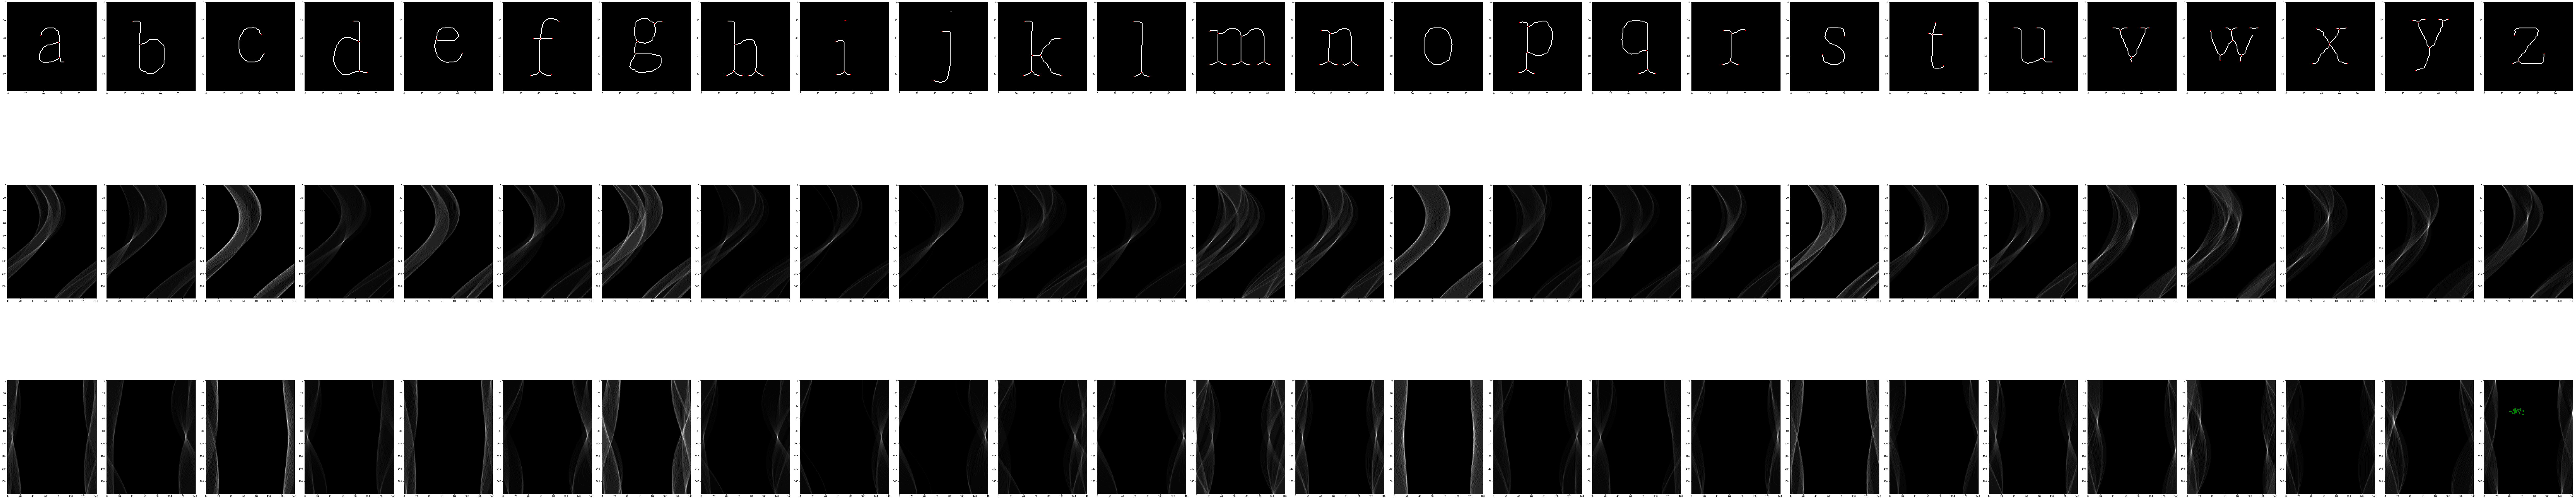

In [78]:
mypath_template = "./Database_Letters/PS600/"
general_path="./Database_Letters/"

im_skeleton=character_preprocessing(mypath_template+'l/001.png')
# print(len(im_skeleton),len(im_skeleton[0]))
# print(findCentroid(im_skeleton))
tab = houghTransform(im_skeleton,90)
# tab2 = houghTransformFromCentroid(im_skeleton,90)
# plt.figure()
# plt.imshow(tab,'gray')
# plt.figure()
# plt.imshow(tab2,'gray')

letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
template = []
houghTrans = []
houghCenterTrans = []
centroids = []

for l in letters:
  im_skeleton = character_preprocessing(mypath_template + l + '/001.png')
  minutia = minutia_extraction(im_skeleton)
  template.append(minutia)
  centroids.append(findCentroid(im_skeleton))

fig, axes = plt.subplots(3, 26, figsize=(160, 40))
ax = axes.ravel()

angleAcc=180

for i in range(26):
  im_skeleton = character_preprocessing(mypath_template + letters[i] + '/001.png')
  houghTrans.append(houghTransform(im_skeleton,angleAcc))
  houghCenterTrans.append(houghTransformFromCentroid(im_skeleton,angleAcc))
#   plt.plot(centroids[i][0],centroids[i][1],color="red")
  #plt.scatter(centroids[i][0],centroids[i][1],color='green')
  ax[i].imshow(draw_minutia(template[i], im_skeleton))
  #plt.scatter(centroids[i][0],centroids[i][1],color='green')
  ax[i+26].imshow(normGrayScale(houghTransform(im_skeleton,angleAcc)),'gray')
  ax[i+52].imshow(normGrayScale(houghTransformFromCentroid(im_skeleton,angleAcc)),'gray')
  
fig.tight_layout()

plt.savefig("hough.png")



In [93]:
def vec2Minus(a,b):
    return [a[0]-b[0],a[1]-b[1]]
def length(v):
    return math.sqrt(np.dot(v,v))
def angle(O,A,B):
    return (math.acos(np.dot(vec2Minus(A,O),vec2Minus(B,O))/(length(vec2Minus(A,O))*length(vec2Minus(B,O)))))

distances = []
relAngles = []
for l in range(26):
    tempD = []
    tempA = []
    
    if len(template[l])!=0:
        refPos=template[l][0]
        for pt in range(len(template[l])):
            tempD.append(euclidean_distance_minutia(centroids[l],template[l][pt]))
            if pt==0:
                tempA.append(0)
            else: 
                tempA.append(angle(centroids[l],refPos,template[l][pt]))
    distances.append(tempD)
    relAngles.append(tempA)
print(distances)
print(relAngles)

[[18.367467172607746, 9.147139260070853, 14.349996825622712, 21.360776419777963], [35.97500885340744, 10.660821443706643], [18.661612504014762, 19.096617010612118], [35.12702335682153, 14.664372619803897, 22.948247332312135, 29.392539450562317], [12.238626023461485, 20.446879371509432], [33.40110451654159, 13.550534166675702, 9.038861090629224, 13.750911403886642, 28.47738601096266, 32.72631867756346, 34.936727943462635], [33.83522478305387, 27.6402555422768, 9.863850890973186, 13.324117739615536], [40.190701173106795, 13.69496991766348, 23.12038496750665, 24.937719690929434, 30.827656557674235, 24.47912428419432, 25.252367635047165, 33.75013602291386], [42.156550169839825, 42.211863129799056, 19.87229366619655, 15.905179100601861, 20.197558983423935, 20.44361486843481], [29.405519592612297, 30.175426714187495], [38.634051762086195, 29.458727437250612, 7.867440639891874, 3.4258753950227416, 22.54484321425979, 30.367141598920522, 24.976855064016547, 35.84006076383738], [33.3684829433563

In [89]:
print(distances[8])
print(distances[9])
print(relAngles[8])
print(relAngles[9])

[42.156550169839825, 42.211863129799056, 19.87229366619655, 15.905179100601861, 20.197558983423935, 20.44361486843481]
[29.405519592612297, 30.175426714187495]
[0, 0.023669820273147343, 0.4670064359855258, 3.045672403168328, 2.8223645960669224, 2.704866909559256]
[0, 2.418664945719378]


In [53]:
print(truths)
kmeans = KMeans(1).fit(truths)
kmeans.cluster_centers_

[[41, 55], [42, 54], [43, 52], [43, 53], [44, 50], [44, 51], [45, 49], [45, 50], [46, 46], [46, 48], [47, 44], [47, 47]]


array([[44.41666667, 49.91666667]])

In [29]:
total=[]
total2=[]

for i in range(len(tab)):
    for j in range(len(tab[i])):
        total.append(tab[i][j])
        total2.append(tab2[i][j])


total.sort(reverse=True)
total2.sort(reverse=True)
print(total[0:15])
print(total2[0:15])

[33, 29, 29, 25, 25, 24, 22, 22, 20, 20, 19, 18, 18, 18, 17]
[33, 33, 31, 31, 31, 31, 29, 26, 25, 24, 23, 22, 21, 21, 19]


In [12]:
mypath_template = "./Database_Letters/PS600/"
general_path="./Database_Letters/"
	
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
template = []

for l in letters:
  im_skeleton = character_preprocessing(mypath_template + l + '/001.png')
  minutia = minutia_extraction(im_skeleton)
  template.append(minutia)


/tmp/ipykernel_17038/264006591.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if structural_elem != 'None':


In [ ]:
for i in range(26):
    print(letters[i] + " : " + str(template[i]))

/tmp/ipykernel_17038/264006591.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if structural_elem != 'None':


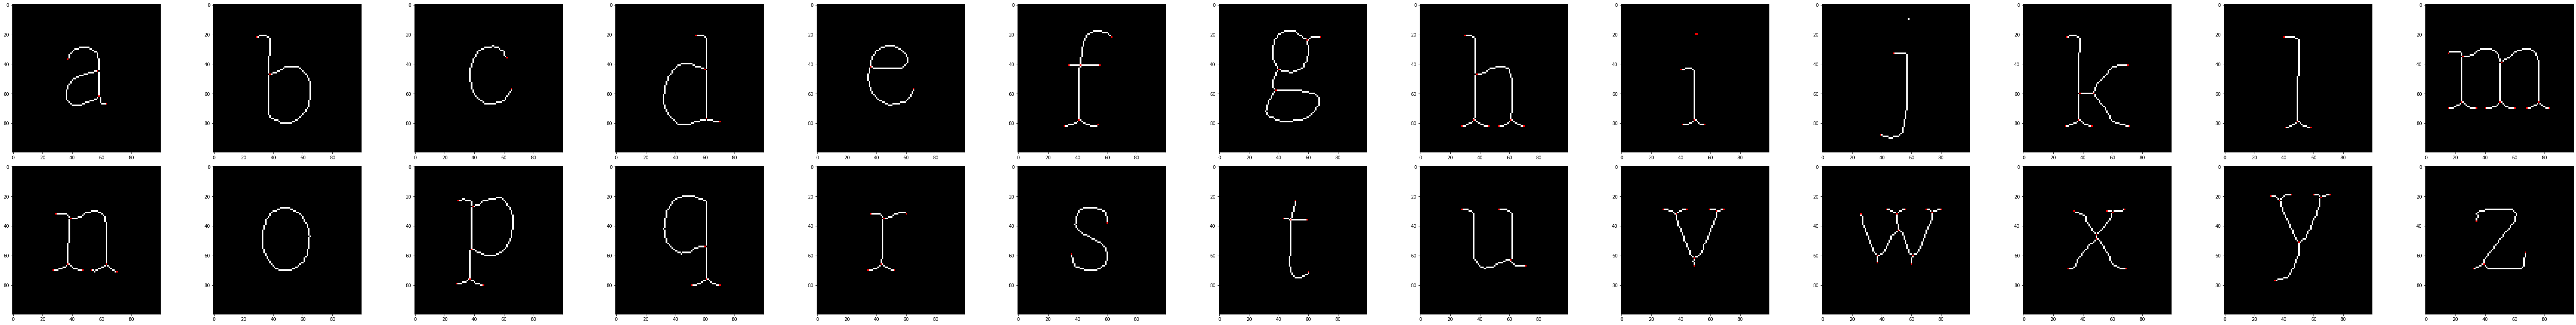

In [13]:
fig, axes = plt.subplots(2, 13, figsize=(80, 10))
ax = axes.ravel()

for i in range(26):
  im_skeleton = character_preprocessing(mypath_template + letters[i] + '/001.png')
  ax[i].imshow(draw_minutia(template[i], im_skeleton))
fig.tight_layout()

In [14]:
smooth_template = []
for m in template:
  smooth_template.append(smoothing(m, 15))

for i in range(26):
    print(letters[i] + " : " + str(smooth_template[i]))

a : [(45, 57, 3), (62, 58, 3), (37, 37, 1)]
b : [(47, 38, 3), (22, 29, 1)]
c : [(36, 62, 1), (57, 65, 1)]
d : [(44, 60, 3), (77, 61, 3), (21, 54, 1)]
e : [(42, 36, 3), (57, 65, 1)]
f : [(41, 42, 4), (78, 41, 3), (22, 63, 1)]
g : [(24, 59, 3), (44, 40, 3), (58, 38, 3)]
h : [(47, 38, 3), (78, 36, 3), (78, 61, 3), (21, 30, 1)]
i : [(78, 49, 3), (20, 50, 1), (20, 51, 1), (44, 40, 1)]
j : [(33, 48, 1), (88, 39, 1)]
k : [(60, 38, 3), (60, 47, 3), (78, 37, 3), (22, 29, 1), (41, 70, 1), (82, 71, 1)]
l : [(79, 49, 3), (22, 40, 1)]
m : [(35, 25, 3), (39, 51, 3), (66, 24, 3), (66, 50, 3), (66, 76, 3)]
n : [(35, 39, 3), (66, 37, 3), (66, 63, 3)]
o : []
p : [(27, 39, 3), (56, 38, 3), (76, 37, 3)]
q : [(54, 60, 3), (76, 61, 3)]
r : [(35, 45, 3), (66, 43, 3), (32, 60, 1)]
s : [(38, 60, 1), (59, 36, 1)]
t : [(36, 48, 4), (71, 60, 1)]
u : [(63, 61, 3), (29, 28, 1), (29, 53, 1)]
v : [(30, 64, 3), (32, 37, 3), (62, 49, 3)]
w : [(31, 74, 3), (32, 50, 3), (43, 51, 3), (60, 37, 3), (60, 61, 3), (32, 26, 1)]

/tmp/ipykernel_17038/264006591.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if structural_elem != 'None':


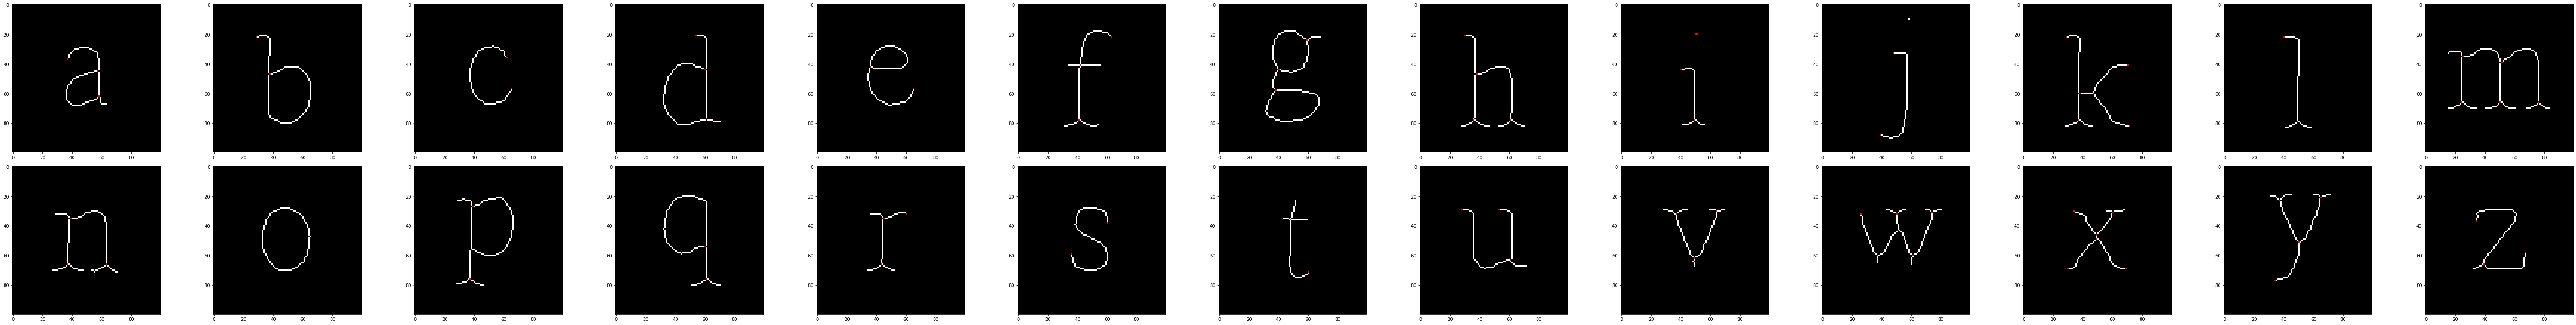

In [15]:
fig, axes = plt.subplots(2, 13, figsize=(80, 10))
ax = axes.ravel()

for i in range(26):
  im_skeleton = character_preprocessing(mypath_template + letters[i] + '/001.png')
  ax[i].imshow(draw_minutia(smooth_template[i], im_skeleton))
fig.tight_layout()

## Main program for matching

### PS300

In [90]:
#mypath = "/content/drive/MyDrive/FuzzyDoc/PS300_resizex2/"
mypath=general_path+"PS300_resizex2/"

methods = [1, 2, 3]

methods_matching_rates = []

for m in methods:
  letters_matching_rates = []
  for l in letters:
    onlyfiles = [f for f in listdir(mypath + l) if isfile(join(mypath + l, f))]
    matching_rate = 0
    for f in onlyfiles:
      im_skeleton = character_preprocessing(mypath + l + '/' + f)
      match = template_comparison(template, im_skeleton, 0, m)
      if (l == letters[match[1]]):
        matching_rate += 1.0
      #print('True letter:', l, 'Predicted letter:', letters[match[1]], 'Scores:', match[0])
      #print(minutia)
    letters_matching_rates.append(matching_rate/len(onlyfiles))
  print("Smooth: No, Method: ", m)
  print("Matching rates (alphabetical order): ", letters_matching_rates)
  print("Average: ", np.mean(letters_matching_rates))
  print("\n")

/tmp/ipykernel_29395/264006591.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if structural_elem != 'None':


Smooth: No, Method:  1
Matching rates (alphabetical order):  [1.0, 0.2, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.2, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.6]
Average:  0.8807692307692307




KeyboardInterrupt: 

In [ ]:
#mypath = "/content/drive/MyDrive/FuzzyDoc/PS300_resizex2/"
mypath=general_path+"PS300_resizex2/"

methods = [1, 2, 3]

methods_matching_rates = []

for m in methods:
  letters_matching_rates = []
  for l in letters:
    onlyfiles = [f for f in listdir(mypath + l) if isfile(join(mypath + l, f))]
    matching_rate = 0
    for f in onlyfiles:
      im_skeleton = character_preprocessing(mypath + l + '/' + f)
      match = template_comparison(smooth_template, im_skeleton, 1, m)
      if (l == letters[match[1]]):
        matching_rate += 1.0
      #print('True letter:', l, 'Predicted letter:', letters[match[1]], 'Scores:', match[0])
      #print(minutia)
    letters_matching_rates.append(matching_rate/len(onlyfiles))
  print("Smooth: Yes, Method: ", m)
  print("Matching rates (alphabetical order): ", letters_matching_rates)
  print("Average: ", np.mean(letters_matching_rates))
  print("\n")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Smooth: Yes, Method:  1
Matching rates (alphabetical order):  [1.0, 0.8, 1.0, 1.0, 0.8, 1.0, 1.0, 0.9, 0.8, 0.9, 1.0, 0.5, 1.0, 0.9, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 0.6]
Average:  0.9192307692307693


Smooth: Yes, Method:  2
Matching rates (alphabetical order):  [1.0, 0.8, 1.0, 0.9, 1.0, 1.0, 1.0, 0.6, 0.6, 1.0, 0.2, 0.5, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7, 1.0, 1.0, 1.0, 1.0, 0.9]
Average:  0.8884615384615384


Smooth: Yes, Method:  3
Matching rates (alphabetical order):  [1.0, 0.8, 1.0, 1.0, 0.8, 1.0, 1.0, 0.9, 0.8, 0.9, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6]
Average:  0.9307692307692309




### PS600

In [ ]:
#mypath = "/content/drive/MyDrive/FuzzyDoc/PS600/"
mypath=general_path+"PS600/"

methods = [1, 2, 3]

methods_matching_rates = []

for m in methods:
  letters_matching_rates = []
  for l in letters:
    onlyfiles = [f for f in listdir(mypath + l) if isfile(join(mypath + l, f))]
    matching_rate = 0
    for f in onlyfiles:
      im_skeleton = character_preprocessing(mypath + l + '/' + f)
      match = template_comparison(template, im_skeleton, 0, m)
      if (l == letters[match[1]]):
        matching_rate += 1.0
      #print('True letter:', l, 'Predicted letter:', letters[match[1]], 'Scores:', match[0])
      #print(minutia)
    letters_matching_rates.append(matching_rate/len(onlyfiles))
  print("Smooth: No, Method: ", m)
  print("Matching rates (alphabetical order): ", letters_matching_rates)
  print("Average: ", np.mean(letters_matching_rates))
  print("\n")

In [ ]:
#mypath = "/content/drive/MyDrive/FuzzyDoc/PS600/"
mypath=general_path+"PS600/"

methods = [1, 2, 3]

methods_matching_rates = []

for m in methods:
  letters_matching_rates = []
  for l in letters:
    onlyfiles = [f for f in listdir(mypath + l) if isfile(join(mypath + l, f))]
    matching_rate = 0
    for f in onlyfiles:
      im_skeleton = character_preprocessing(mypath + l + '/' + f)
      match = template_comparison(smooth_template, im_skeleton, 1, m)
      if (l == letters[match[1]]):
        matching_rate += 1.0
      #print('True letter:', l, 'Predicted letter:', letters[match[1]], 'Scores:', match[0])
      #print(minutia)
    letters_matching_rates.append(matching_rate/len(onlyfiles))
  print("Smooth: Yes, Method: ", m)
  print("Matching rates (alphabetical order): ", letters_matching_rates)
  print("Average: ", np.mean(letters_matching_rates))
  print("\n")

### 2PS600

In [ ]:
#mypath = "/content/drive/MyDrive/FuzzyDoc/2PS600/"
mypath=general_path+"2PS600/"

methods = [1, 2, 3]

methods_matching_rates = []

for m in methods:
  letters_matching_rates = []
  for l in letters:
    onlyfiles = [f for f in listdir(mypath + l) if isfile(join(mypath + l, f))]
    matching_rate = 0
    for f in onlyfiles:
      im_skeleton = character_preprocessing(mypath + l + '/' + f)
      match = template_comparison(template, im_skeleton, 0, m)
      if (l == letters[match[1]]):
        matching_rate += 1.0
      #print('True letter:', l, 'Predicted letter:', letters[match[1]], 'Scores:', match[0])
      #print(minutia)
    letters_matching_rates.append(matching_rate/len(onlyfiles))
  print("Smooth: No, Method: ", m)
  print("Matching rates (alphabetical order): ", letters_matching_rates)
  print("Average: ", np.mean(letters_matching_rates))
  print("\n")

In [ ]:
#mypath = "/content/drive/MyDrive/FuzzyDoc/2PS600/"
mypath=general_path+"2PS600/"

methods = [1, 2, 3]

methods_matching_rates = []

for m in methods:
  letters_matching_rates = []
  for l in letters:
    onlyfiles = [f for f in listdir(mypath + l) if isfile(join(mypath + l, f))]
    matching_rate = 0
    for f in onlyfiles:
      im_skeleton = character_preprocessing(mypath + l + '/' + f)
      match = template_comparison(smooth_template, im_skeleton, 1, m)
      if (l == letters[match[1]]):
        matching_rate += 1.0
      #print('True letter:', l, 'Predicted letter:', letters[match[1]], 'Scores:', match[0])
      #print(minutia)
    letters_matching_rates.append(matching_rate/len(onlyfiles))
  print("Smooth: Yes, Method: ", m)
  print("Matching rates (alphabetical order): ", letters_matching_rates)
  print("Average: ", np.mean(letters_matching_rates))
  print("\n")

## Full example of the pre-processing operations 

In [ ]:
path = "/content/drive/MyDrive/FuzzyDoc/PS300/b/001.png"

im_orig = imread(path, as_gray=True)
im_rescale = load_image(path)
im_preprocess = opening_image(im_rescale, structural_elem = square(3))
im_bin = binarization_image(im_preprocess, 'otsu')
im_skeleton_zhang = skeletonization_image(im_bin, 'zhang')
im_skeleton_lee = skeletonization_image(im_bin, 'lee')

fig, axes = plt.subplots(1, 6, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(im_orig, cmap=plt.cm.gray)
ax[0].set_title('Original image', fontsize=15)
ax[1].imshow(im_rescale, cmap=plt.cm.gray)
ax[1].set_title('Resized image', fontsize=15)
ax[2].imshow(im_preprocess, cmap=plt.cm.gray)
ax[2].set_title('Pre-processed image', fontsize=15)
ax[3].imshow(im_bin, cmap=plt.cm.gray)
ax[3].set_title('Binary image', fontsize=15)
ax[4].imshow(im_skeleton_zhang, cmap=plt.cm.gray)
ax[4].set_title('Skeleton (Zhang)', fontsize=15)
ax[5].imshow(im_skeleton_lee, cmap=plt.cm.gray)
ax[5].set_title('Skeleton (Lee)', fontsize=15)

fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
